In [1]:
# query NVIDIA GPU devices on a system
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-b77992e8-e576-833e-286b-fcb313f79dda)


In [2]:
# Get the Active vision dataset
# https://www.cs.unc.edu/~ammirato/active_vision_dataset_website/index.html
!gdown 0B8zhxvoYK3WTVHNpTjNMUzRtTWM

Downloading...
From (original): https://drive.google.com/uc?id=0B8zhxvoYK3WTVHNpTjNMUzRtTWM
From (redirected): https://drive.google.com/uc?id=0B8zhxvoYK3WTVHNpTjNMUzRtTWM&confirm=t&uuid=9ede7fb2-dc36-4237-a183-dbe65e3b9a12
To: /content/ActiveVisionDataset_example_scene.tar
100% 1.21G/1.21G [00:44<00:00, 27.4MB/s]


In [3]:
# Extract the data from the dataset
!tar -xvf /content/ActiveVisionDataset_example_scene.tar

ActiveVisionDataset/example_scene/Home_003_1/high_res_depth/000310013670103.png
ActiveVisionDataset/example_scene/Home_003_1/high_res_depth/000310003100103.png
ActiveVisionDataset/example_scene/Home_003_1/high_res_depth/000310010150103.png
ActiveVisionDataset/example_scene/Home_003_1/high_res_depth/000310003640103.png
ActiveVisionDataset/example_scene/Home_003_1/jpg_rgb/000310005830101.jpg
ActiveVisionDataset/example_scene/Home_003_1/high_res_depth/000310013740103.png
ActiveVisionDataset/example_scene/Home_003_1/high_res_depth/000310006100103.png
ActiveVisionDataset/example_scene/Home_003_1/high_res_depth/000310011920103.png
ActiveVisionDataset/example_scene/Home_003_1/jpg_rgb/000310014090101.jpg
ActiveVisionDataset/example_scene/Home_003_1/high_res_depth/000310006640103.png
ActiveVisionDataset/example_scene/Home_003_1/jpg_rgb/000310008830101.jpg
ActiveVisionDataset/example_scene/Home_003_1/high_res_depth/000310010080103.png
ActiveVisionDataset/example_scene/Home_003_1/high_res_depth/0

In [4]:
import sys

# clone the vlmaps repository
!git clone https://github.com/vlmaps/vlmaps.git

%cd /content/vlmaps/vlmaps/

# Get the required dependencies
!pip install timm
import os
import math
import numpy as np
import cv2
from tqdm import tqdm
import torch
import torchvision.transforms as transforms

!pip install clip
import clip

import utils
from lseg.modules.models.lseg_net import LSegEncNet
from lseg.additional_utils.models import resize_image, pad_image, crop_image
from PIL import Image
import matplotlib.patches as mpatches

/content/vlmaps/vlmaps


In [5]:
!pip install git+https://github.com/openai/CLIP.git --user
!pip install pytorch_lightning

%cd /content/vlmaps/lseg
!mkdir checkpoints
%cd checkpoints
!gdown 1ayk6NXURI_vIPlym16f_RG3ffxBWHxvb
!ls
%cd /content/vlmaps

import torch
import clip

mask_version = 1 # 0, 1

crop_size = 480 # 480
base_size = 520 # 520
lang = "door,chair,ground,ceiling,other"
labels = lang.split(",")


# loading models
#device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
clip_version = "ViT-B/32"
clip_feat_dim = {'RN50': 1024, 'RN101': 512, 'RN50x4': 640, 'RN50x16': 768,
                'RN50x64': 1024, 'ViT-B/32': 512, 'ViT-B/16': 512, 'ViT-L/14': 768}[clip_version]
print("Loading CLIP model...")
clip_model, preprocess = clip.load(clip_version)  # clip.available_models()

clip_model.to(device).eval()
lang_token = clip.tokenize(labels)
lang_token = lang_token.to(device)
with torch.no_grad():
    text_feats = clip_model.encode_text(lang_token)
    text_feats = text_feats / text_feats.norm(dim=-1, keepdim=True)
text_feats = text_feats.cpu().numpy()
model = LSegEncNet(lang, arch_option=0,
                    block_depth=0,
                    activation='lrelu',
                    crop_size=crop_size)
model_state_dict = model.state_dict()
pretrained_state_dict = torch.load("/content/vlmaps/vlmaps/checkpoints/demo_e200.ckpt")
#pretrained_state_dict = torch.load("/content/vlmaps/vlmaps/checkpoints/demo_e200.ckpt", map_location=torch.device('cpu'))
pretrained_state_dict = {k.lstrip('net.'): v for k, v in pretrained_state_dict['state_dict'].items()}
model_state_dict.update(pretrained_state_dict)
model.load_state_dict(pretrained_state_dict)

model.eval()
model = model.to(device)

norm_mean= [0.5, 0.5, 0.5]
norm_std = [0.5, 0.5, 0.5]
padding = [0.0] * 3
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    ]
)


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-zv9krcoo
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-zv9krcoo
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Using cached pytorch_lightning-2.2.4-py3-none-any.whl (802 kB)
  Using cached torchmetrics-1.4.0-py3-none-any.whl (868 kB)
  Using cached lightning_utilities-0.11.2-py3-none-any.whl (26 kB)
  Using cached pretty_errors-1.2.25-py3-none-any.whl (17 kB)
  Using cached colorama-0.4.6-py2.py3-none-any.whl (25 kB)
[Errno 2] No such file or directory: '/content/vlmaps/lseg'
/content/vlmaps/vlmaps
mkdir: cannot create directory ‘checkpoints’: File exists
/content/vlmaps/vlmaps/checkpoints
Downloading...
From (original): https://drive.google.com/uc?id=1ayk6NXURI_vIPlym16f_RG3ffxBWHxvb
From (redirected): https://drive.google.com/uc?id=1ayk6NXURI_vIPlym16f_RG3ffxBWHxvb

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 182MiB/s]
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

In [7]:
def load_pose(pose_filepath):
    pos_list, rot_list = [], []
    with open(pose_filepath, "r") as f:
        lines = f.readlines()
        for line in lines:
            row = [float(x) for x in line.split()]
            pos = np.array(row[:3], dtype=float).reshape((3, 1))
            quat = row[3:]
            r = R.from_quat(quat)
            rot = r.as_matrix()

            pos_list.append(pos)
            rot_list.append(rot)

        return pos_list, rot_list

def cvt_obj_id_2_cls_id(semantic: np.array, obj2cls: dict):
    h, w = semantic.shape
    semantic = semantic.flatten()
    u, inv = np.unique(semantic, return_inverse=True)
    return np.array([obj2cls[x][0] for x in u])[inv].reshape((h, w))

def get_sim_cam_mat_with_fov(h, w, fov):

    cam_mat = np.eye(3)
    cam_mat[0, 0] = cam_mat[1, 1] = w / (2.0 * np.tan(np.deg2rad(fov / 2)))
    cam_mat[0, 2] = w / 2.0
    cam_mat[1, 2] = h / 2.0
    return cam_mat

def depth2pc(depth, fov=90):
    """
    Return 3xN array
    """

    h, w = depth.shape

    cam_mat = get_sim_cam_mat_with_fov(h, w, fov)
    cam_mat_inv = np.linalg.inv(cam_mat)

    y, x = np.meshgrid(np.arange(h), np.arange(w), indexing="ij")

    x = x.reshape((1, -1))[:, :]
    y = y.reshape((1, -1))[:, :]
    z = depth.reshape((1, -1))[:, :]

    p_2d = np.vstack([x, y, np.ones_like(x)])
    pc = cam_mat_inv @ p_2d
    pc = pc * z
    mask = pc[2, :] > 0.1
    return pc, mask

def transform_pc(pc, pose):
    """
    pose: the pose of the camera coordinate where the pc is in
    """
    pc_homo = np.vstack([pc, np.ones((1, pc.shape[1]))])

    pc_global_homo = pose @ pc_homo

    return pc_global_homo[:3, :]


def get_sim_cam_mat(h, w):

    cam_mat = np.eye(3)
    cam_mat[0, 0] = cam_mat[1, 1] = w / 2.0
    cam_mat[0, 2] = w / 2.0
    cam_mat[1, 2] = h / 2.0
    return cam_mat

def pos2grid_id(gs, cs, xx, yy):
    x = int(gs / 2 + int(xx / cs))
    y = int(gs / 2 - int(yy / cs))
    return [x, y]

def project_point(cam_mat, p):
    new_p = cam_mat @ p.reshape((3, 1))
    z = new_p[2, 0]
    new_p = new_p / new_p[2, 0]
    x = int(new_p[0, 0] + 0.5)
    y = int(new_p[1, 0] + 0.5)
    return x, y, z

In [8]:
def get_lseg_feat(model: LSegEncNet, image: np.array, labels, transform, crop_size=480, \
                 base_size=520, norm_mean=[0.5, 0.5, 0.5], norm_std=[0.5, 0.5, 0.5]):
    vis_image = image.copy()
    image = transform(image).unsqueeze(0).cuda()
    img = image[0].permute(1,2,0)
    img = img * 0.5 + 0.5

    batch, _, h, w = image.size()
    stride_rate = 2.0/3.0
    stride = int(crop_size * stride_rate)

    long_size = base_size
    if h > w:
        height = long_size
        width = int(1.0 * w * long_size / h + 0.5)
        short_size = width
    else:
        width = long_size
        height = int(1.0 * h * long_size / w + 0.5)
        short_size = height


    cur_img = resize_image(image, height, width, **{'mode': 'bilinear', 'align_corners': True})

    if long_size <= crop_size:
        pad_img = pad_image(cur_img, norm_mean,
                            norm_std, crop_size)
        print(pad_img.shape)
        with torch.no_grad():
            outputs, logits = model(pad_img, labels)
        outputs = crop_image(outputs, 0, height, 0, width)
    else:
        if short_size < crop_size:
            # pad if needed
            pad_img = pad_image(cur_img, norm_mean,
                                norm_std, crop_size)
        else:
            pad_img = cur_img
        _,_,ph,pw = pad_img.shape #.size()
        assert(ph >= height and pw >= width)
        h_grids = int(math.ceil(1.0 * (ph-crop_size)/stride)) + 1
        w_grids = int(math.ceil(1.0 * (pw-crop_size)/stride)) + 1
        with torch.cuda.device_of(image):
            with torch.no_grad():
                outputs = image.new().resize_(batch, model.out_c,ph,pw).zero_().cuda()
                logits_outputs = image.new().resize_(batch, len(labels),ph,pw).zero_().cuda()
            count_norm = image.new().resize_(batch,1,ph,pw).zero_().cuda()
        # grid evaluation
        for idh in range(h_grids):
            for idw in range(w_grids):
                h0 = idh * stride
                w0 = idw * stride
                h1 = min(h0 + crop_size, ph)
                w1 = min(w0 + crop_size, pw)
                crop_img = crop_image(pad_img, h0, h1, w0, w1)
                # pad if needed
                pad_crop_img = pad_image(crop_img, norm_mean,
                                            norm_std, crop_size)
                with torch.no_grad():
                    output, logits = model(pad_crop_img, labels)
                cropped = crop_image(output, 0, h1-h0, 0, w1-w0)
                cropped_logits = crop_image(logits, 0, h1-h0, 0, w1-w0)
                outputs[:,:,h0:h1,w0:w1] += cropped
                logits_outputs[:,:,h0:h1,w0:w1] += cropped_logits
                count_norm[:,:,h0:h1,w0:w1] += 1
        assert((count_norm==0).sum()==0)
        outputs = outputs / count_norm
        logits_outputs = logits_outputs / count_norm
        outputs = outputs[:,:,:height,:width]
        logits_outputs = logits_outputs[:,:,:height,:width]
    outputs = outputs.cpu()
    outputs = outputs.numpy() # B, D, H, W
    predicts = [torch.max(logit, 0)[1].cpu().numpy() for logit in logits_outputs]
    pred = predicts[0]

    return outputs

def get_text_feats(in_text, clip_model, clip_feat_dim, batch_size=64):
    text_tokens = clip.tokenize(in_text).cuda()
    text_id = 0
    text_feats = np.zeros((len(in_text), clip_feat_dim), dtype=np.float32)
    while text_id < len(text_tokens):  # Batched inference.
        batch_size = min(len(in_text) - text_id, batch_size)
        text_batch = text_tokens[text_id : text_id + batch_size]
        with torch.no_grad():
            batch_feats = clip_model.encode_text(text_batch).float()
        batch_feats /= batch_feats.norm(dim=-1, keepdim=True)
        batch_feats = np.float32(batch_feats.cpu())
        text_feats[text_id : text_id + batch_size, :] = batch_feats
        text_id += batch_size
    return text_feats


def get_new_mask_pallete(npimg, new_palette, out_label_flag=False, labels=None, ignore_ids_list=[]):
    """Get image color pallete for visualizing masks"""
    # put colormap
    out_img = Image.fromarray(npimg.squeeze().astype("uint8"))
    out_img.putpalette(new_palette)

    if out_label_flag:
        assert labels is not None
        u_index = np.unique(npimg)
        patches = []
        for i, index in enumerate(u_index):
            if index in ignore_ids_list:
                continue
            label = labels[index]
            cur_color = [
                new_palette[index * 3] / 255.0,
                new_palette[index * 3 + 1] / 255.0,
                new_palette[index * 3 + 2] / 255.0,
            ]
            red_patch = mpatches.Patch(color=cur_color, label=label)
            patches.append(red_patch)
    return out_img, patches

def get_new_pallete(num_cls):
    n = num_cls
    pallete = [0] * (n * 3)

    for j in range(0, n):
        lab = j
        pallete[j * 3 + 0] = 0
        pallete[j * 3 + 1] = 0
        pallete[j * 3 + 2] = 0
        i = 0
        while lab > 0:
            pallete[j * 3 + 0] |= ((lab >> 0) & 1) << (7 - i)
            pallete[j * 3 + 1] |= ((lab >> 1) & 1) << (7 - i)
            pallete[j * 3 + 2] |= ((lab >> 2) & 1) << (7 - i)
            i = i + 1
            lab >>= 3
    return pallete

In [9]:
base_path = f'/content/ActiveVisionDataset/example_scene/Home_003_1'
tf_list = []
camera_height = 1.5
depth_sample_rate = 100
cs = 0.05
gs = 1000

In [10]:
# %cat {base_path}/poses.txt
import glob
len(glob.glob(f'{base_path}/rgb/*.png'))

0

In [11]:
# initialize a grid with zero position at the center
color_top_down_height = (camera_height + 1) * np.ones((gs, gs), dtype=np.float32)
color_top_down = np.zeros((gs, gs, 3), dtype=np.uint8)
gt = np.zeros((gs, gs), dtype=np.int32)
grid = np.zeros((gs, gs, clip_feat_dim), dtype=np.float32)
obstacles = np.ones((gs, gs), dtype=np.uint8)
weight = np.zeros((gs, gs), dtype=float)

tf_list = []

In [12]:
from glob import glob

glob('/content/ActiveVisionDataset/example_scene/Home_003_1/jpg_rgb/*.jpg')

['/content/ActiveVisionDataset/example_scene/Home_003_1/jpg_rgb/000310001550101.jpg',
 '/content/ActiveVisionDataset/example_scene/Home_003_1/jpg_rgb/000310001850101.jpg',
 '/content/ActiveVisionDataset/example_scene/Home_003_1/jpg_rgb/000310000410101.jpg',
 '/content/ActiveVisionDataset/example_scene/Home_003_1/jpg_rgb/000310009600101.jpg',
 '/content/ActiveVisionDataset/example_scene/Home_003_1/jpg_rgb/000310006560101.jpg',
 '/content/ActiveVisionDataset/example_scene/Home_003_1/jpg_rgb/000310002640101.jpg',
 '/content/ActiveVisionDataset/example_scene/Home_003_1/jpg_rgb/000310013500101.jpg',
 '/content/ActiveVisionDataset/example_scene/Home_003_1/jpg_rgb/000310006200101.jpg',
 '/content/ActiveVisionDataset/example_scene/Home_003_1/jpg_rgb/000310008740101.jpg',
 '/content/ActiveVisionDataset/example_scene/Home_003_1/jpg_rgb/000310004840101.jpg',
 '/content/ActiveVisionDataset/example_scene/Home_003_1/jpg_rgb/000310014120101.jpg',
 '/content/ActiveVisionDataset/example_scene/Home_003_

In [13]:
import scipy.io

mat = scipy.io.loadmat('/content/ActiveVisionDataset/example_scene/Home_003_1/image_structs.mat')

In [14]:
pose_names_list = mat['image_structs'][0]
pose_names_list

# Reading poses
pos_dict = {}
rot_dict = {}

for i in range(len(pose_names_list)):

  pos_dict[pose_names_list[i][0][0]] = pose_names_list[i][1]
  rot_dict[pose_names_list[i][0][0]] = pose_names_list[i][2]

In [16]:

from glob import glob

def load_avd_depth_image(path):

    """ Load a depth image from the Active Vision Dataset and convert it to meters. """

    with Image.open(path) as img:

        depth_image = np.array(img, dtype=np.uint16)



    # Convert to actual depth values for AVD, where 1 unit = 1 mm, convert to meters

    depth_in_meters = depth_image / 1000.0  # Convert millimeters to meters

    return depth_in_meters

# pos_list, rot_list = load_pose(f'{base_path}/poses.txt')

#for idx in range(100):
    # idx = 5

rgb_list = glob('/content/ActiveVisionDataset/example_scene/Home_003_1/jpg_rgb/*.jpg')

print("Size of rgb_list:", len(rgb_list))

for i in rgb_list:

    img_name_key = i.split('/')[-1]

    bgr = cv2.imread(i)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    # rgb = rgb.to(device)

    # read pose
    pos, rot = pos_dict[img_name_key], rot_dict[img_name_key]  # z backward, y upward, x to the right

    rot_ro_cam = np.eye(3)

    rot_shape = rot.shape
    rot_ro_cam_shape = rot_ro_cam.shape

    print("Dimensions of rot:", rot_shape)
    print("Dimensions of rot_ro_cam:", rot_ro_cam_shape)

    if rot.shape == (0, 0):
      continue


    rot_ro_cam[1, 1] = -1
    rot_ro_cam[2, 2] = -1
    # rot = rot @ rot_ro_cam
    rot = np.matmul(rot, rot_ro_cam)
    pos[1] += camera_height


    pose = np.eye(4)
    pose[:3, :3] = rot
    pose[:3, 3] = pos.reshape(-1)

    tf_list.append(pose)
    if len(tf_list) == 1:
        init_tf_inv = np.linalg.inv(tf_list[0])

    tf = init_tf_inv @ pose

    # read depth
    # depth = np.load(f'{base_path}/depth/{idx:06}.npy')

    single_depth_image = i.replace('jpg_rgb', 'high_res_depth')
    single_depth_image = single_depth_image.replace('01.jpg', '03.png')

    depth = load_avd_depth_image(single_depth_image)
    # depth = np.load()

    # read semantic
    # semantic = np.load(f'{base_path}/semantic/{idx:06}.npy')
    # semantic = cvt_obj_id_2_cls_id(semantic, obj2cls)

    pix_feats = get_lseg_feat(model, rgb, labels, transform, crop_size, base_size, norm_mean, norm_std)

    # plt.imshow(rgb)
    # plt.imshow(depth)
    # plt.imshow(semantic)

    ########################################################
    # transform all points to the global frame

    pc, mask = depth2pc(depth)
    shuffle_mask = np.arange(pc.shape[1])
    np.random.shuffle(shuffle_mask)
    shuffle_mask = shuffle_mask[::depth_sample_rate]
    mask = mask[shuffle_mask]
    pc = pc[:, shuffle_mask]
    pc = pc[:, mask]
    pc_global = transform_pc(pc, tf)

    ######################################
    rgb_cam_mat = get_sim_cam_mat(rgb.shape[0], rgb.shape[1])
    feat_cam_mat = get_sim_cam_mat(pix_feats.shape[2], pix_feats.shape[3])

    count = 0
    px_list = []
    py_list = []
    pz_list = []

    # project all point cloud onto the ground
    for i, (p, p_local) in enumerate(zip(pc_global.T, pc.T)):
        x, y = pos2grid_id(gs, cs, p[0], p[2])

        # ignore points projected to outside of the map and points that are 0.5 higher than the camera (could be from the ceiling)
        if x >= obstacles.shape[0] or y >= obstacles.shape[1] or \
            x < 0 or y < 0 or p_local[1] < -0.5:
            continue

        rgb_px, rgb_py, rgb_pz = project_point(rgb_cam_mat, p_local)
        rgb_v = rgb[rgb_py, rgb_px, :]
        # semantic_v = semantic[rgb_py, rgb_px]
        # if semantic_v == 40:
        #     semantic_v = -1

        # when the projected location is already assigned a color value before, overwrite if the current point has larger height
        if p_local[1] < color_top_down_height[y, x]:
            color_top_down[y, x] = rgb_v
            color_top_down_height[y, x] = p_local[1]
            # gt[y, x] = semantic_v


        # average the visual embeddings if multiple points are projected to the same grid cell
        px, py, pz = project_point(feat_cam_mat, p_local)

        if not (px < 0 or py < 0 or px >= pix_feats.shape[3] or py >= pix_feats.shape[2]):
            feat = pix_feats[0, :, py, px]
            grid[y, x] = (grid[y, x] * weight[y, x] + feat) / (weight[y, x] + 1)
            weight[y, x] += 1

        # build an obstacle map ignoring points on the floor (0 means occupied, 1 means free)
        if p_local[1] > camera_height:
            continue
        obstacles[y, x] = 0


Size of rgb_list: 1500
Dimensions of rot: (3, 3)
Dimensions of rot_ro_cam: (3, 3)
Dimensions of rot: (3, 3)
Dimensions of rot_ro_cam: (3, 3)
Dimensions of rot: (0, 0)
Dimensions of rot_ro_cam: (3, 3)
Dimensions of rot: (3, 3)
Dimensions of rot_ro_cam: (3, 3)
Dimensions of rot: (3, 3)
Dimensions of rot_ro_cam: (3, 3)
Dimensions of rot: (3, 3)
Dimensions of rot_ro_cam: (3, 3)
Dimensions of rot: (3, 3)
Dimensions of rot_ro_cam: (3, 3)
Dimensions of rot: (3, 3)
Dimensions of rot_ro_cam: (3, 3)
Dimensions of rot: (3, 3)
Dimensions of rot_ro_cam: (3, 3)
Dimensions of rot: (3, 3)
Dimensions of rot_ro_cam: (3, 3)
Dimensions of rot: (0, 0)
Dimensions of rot_ro_cam: (3, 3)
Dimensions of rot: (0, 0)
Dimensions of rot_ro_cam: (3, 3)
Dimensions of rot: (3, 3)
Dimensions of rot_ro_cam: (3, 3)
Dimensions of rot: (3, 3)
Dimensions of rot_ro_cam: (3, 3)
Dimensions of rot: (3, 3)
Dimensions of rot_ro_cam: (3, 3)
Dimensions of rot: (3, 3)
Dimensions of rot_ro_cam: (3, 3)
Dimensions of rot: (3, 3)
Dimensi

KeyboardInterrupt: 

In [17]:
x_indices, y_indices = np.where(obstacles == 0)

xmin = np.min(x_indices)
xmax = np.max(x_indices)
ymin = np.min(y_indices)
ymax = np.max(y_indices)

print(xmin, xmax, ymin, ymax)


217 798 340 742


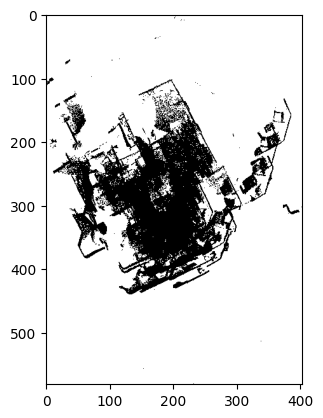

In [18]:
# Create obstacle map
plt.imshow(obstacles[xmin:xmax+1, ymin:ymax+1], cmap='gray')

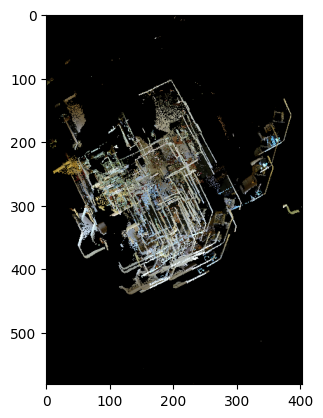

In [33]:
# create RBG map
plt.imshow(color_top_down[xmin:xmax+1,ymin:ymax+1,:])

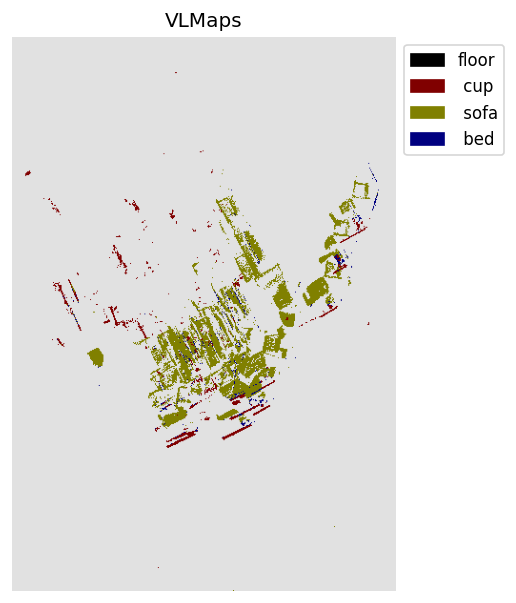

In [20]:
# Create Semantic Map
small_grid = grid[xmin:xmax+1, ymin:ymax+1].copy()
no_map_mask = obstacles[xmin:xmax+1, ymin:ymax+1] > 0

# @markdown Input the prompt as a string of object names separated by ","
lang = "floor, cup, banana, sofa, bed" # @param {type: "string"}
lang = lang.split(",")
text_feats = get_text_feats(lang, clip_model, clip_feat_dim)

map_feats = small_grid.reshape((-1, grid.shape[-1]))
scores_list = map_feats @ text_feats.T

predicts = np.argmax(scores_list, axis=1)
predicts = predicts.reshape((xmax - xmin + 1, ymax - ymin + 1))
floor_mask = predicts == 0

new_pallete = get_new_pallete(len(lang))
mask, patches = get_new_mask_pallete(predicts, new_pallete, out_label_flag=True, labels=lang)
seg = mask.convert("RGBA")
seg = np.array(seg)
seg[no_map_mask] = [225, 225, 225, 255]
seg[floor_mask] = [225, 225, 225, 255]
seg = Image.fromarray(seg)
plt.figure(figsize=(10, 6), dpi=120)
plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
plt.axis('off')
plt.title("VLMaps")
plt.imshow(seg)
plt.show()

In [22]:
for idx, obj in enumerate(lang):
    predicts = scores_list[:, idx]
    predicts = predicts.reshape((xmax - xmin + 1, ymax - ymin + 1))

    new_pallete = get_new_pallete(1)
    mask, patches = get_new_mask_pallete(predicts, new_pallete, out_label_flag=True, labels=[obj])
    seg = mask.convert("RGBA")
    seg = np.array(seg)
    seg[no_map_mask] = [225, 225, 225, 255]
    seg[floor_mask] = [225, 225, 225, 255]
    seg = Image.fromarray(seg)
    plt.figure(figsize=(10, 6), dpi=120)
    plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(1., 1), prop={'size': 10})
    plt.axis('off')
    plt.title(obj)
    plt.imshow(seg)
    plt.show()

TypeError: list indices must be integers or slices, not numpy.float32

In [23]:
 get_new_pallete(1)

[0, 0, 0]

In [24]:
# transform all points to the global frame

pc, mask = depth2pc(depth)
shuffle_mask = np.arange(pc.shape[1])
np.random.shuffle(shuffle_mask)
shuffle_mask = shuffle_mask[::depth_sample_rate]
mask = mask[shuffle_mask]
pc = pc[:, shuffle_mask]
pc = pc[:, mask]
pc_global = transform_pc(pc, tf)

In [25]:
rgb_cam_mat = get_sim_cam_mat(rgb.shape[0], rgb.shape[1])
feat_cam_mat = get_sim_cam_mat(pix_feats.shape[2], pix_feats.shape[3])

# project all point cloud onto the ground
for i, (p, p_local) in enumerate(zip(pc_global.T, pc.T)):
    x, y = pos2grid_id(gs, cs, p[0], p[2])

    # ignore points projected to outside of the map and points that are 0.5 higher than the camera (could be from the ceiling)
    if x >= obstacles.shape[0] or y >= obstacles.shape[1] or \
        x < 0 or y < 0 or p_local[1] < -0.5:
        continue

    rgb_px, rgb_py, rgb_pz = project_point(rgb_cam_mat, p_local)
    rgb_v = rgb[rgb_py, rgb_px, :]
    # semantic_v = semantic[rgb_py, rgb_px]
    # if semantic_v == 40:
    #     semantic_v = -1

    # when the projected location is already assigned a color value before, overwrite if the current point has larger height
    if p_local[1] < color_top_down_height[y, x]:
        color_top_down[y, x] = rgb_v
        color_top_down_height[y, x] = p_local[1]
        # gt[y, x] = semantic_v

    # average the visual embeddings if multiple points are projected to the same grid cell
    px, py, pz = project_point(feat_cam_mat, p_local)
    if not (px < 0 or py < 0 or px >= pix_feats.shape[3] or py >= pix_feats.shape[2]):
        feat = pix_feats[0, :, py, px]
        grid[y, x] = (grid[y, x] * weight[y, x] + feat) / (weight[y, x] + 1)
        weight[y, x] += 1

    # build an obstacle map ignoring points on the floor (0 means occupied, 1 means free)
    if p_local[1] > camera_height:
        continue
    obstacles[y, x] = 0

In [26]:
grid.shape, weight.shape, obstacles.shape

((1000, 1000, 512), (1000, 1000), (1000, 1000))

In [27]:
for obj in lang:
    print(obj)

floor
cup
banana
sofa
bed


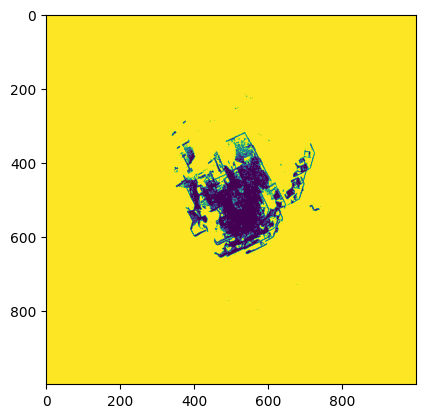

In [28]:
# Create Obstacle heatmap
plt.imshow(obstacles)

In [29]:
load_pose(f'{base_path}/poses.txt')

FileNotFoundError: [Errno 2] No such file or directory: '/content/ActiveVisionDataset/example_scene/Home_003_1/poses.txt'

In [30]:
%cat {base_path}/poses.txt

cat: /content/ActiveVisionDataset/example_scene/Home_003_1/poses.txt: No such file or directory


In [31]:
import plotly.graph_objects as go

In [32]:
fig = go.Figure(data=[go.Scatter3d(x=pc_global[0,:],
                                   y=pc_global[1,:],
                                   z=pc_global[2,:],
                                   mode='markers')])
fig.show()

In [ ]:
import os
import numpy as np
from PIL import Image
import cv2

# # Define the source folder path where .png files are located
# source_folder = '/content/ActiveVisionDataset/example_scene/Home_003_1/high_res_depth'

# # Define the destination folder path where .npy files should be saved
# destination_folder = '/content/ActiveVisionDataset/example_scene/Home_003_1/new_depth'  # Replace with your desired folder path


# img = cv2.imread('/content/ActiveVisionDataset/example_scene/Home_003_1/high_res_depth/000310000010103.png')
# print(img.max())

from PIL import Image

import numpy as np



def load_avd_depth_image(path):

    """ Load a depth image from the Active Vision Dataset and convert it to meters. """

    with Image.open(path) as img:

        depth_image = np.array(img, dtype=np.uint16)



    # Convert to actual depth values for AVD, where 1 unit = 1 mm, convert to meters

    depth_in_meters = depth_image / 1000.0  # Convert millimeters to meters



    return depth_in_meters



# Example usage:

# Replace 'path/to/your/depth_image.png' with the actual path to your AVD depth image

path_to_depth_image = '/content/ActiveVisionDataset/example_scene/Home_003_1/high_res_depth/000310000010103.png'

depth_values = load_avd_depth_image(path_to_depth_image)



print("Depth values in meters:\n", depth_values.max())

In [ ]:
#type()
print(depth_values.dtype)